# Deep Q-Network implementation.

This homework shamelessly demands you to implement DQN — an approximate Q-learning algorithm with experience replay and target networks — and see if it works any better this way.

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

**This notebook is the main notebook.** Another notebook is given for debug. (**homework_pytorch_debug**). The tasks are similar and share most of the code. The main difference is in environments. In main notebook it can take some 2 hours for the agent to start improving so it seems reasonable to launch the algorithm on a simpler env first. In debug one it is CartPole and it will train in several minutes.

**We suggest the following pipeline:** First implement debug notebook then implement the main one.

**About evaluation:** All points are given for the main notebook with one exception: if agent fails to beat the threshold in main notebook you can get 1 pt (instead of 3 pts) for beating the threshold in debug notebook.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/utils.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/framebuffer.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install 'gymnasium[atari,accept-rom-license]'

In [3]:
import random
import numpy as np
import torch
import utils

In [21]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Let's play some old videogames
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/nerd.png)

This time we're gonna apply approximate Q-learning to an Atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.


In [5]:
ENV_NAME = "BreakoutNoFrameskip-v4"

## Preprocessing (3 pts)

Let's see what observations look like.

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/ahmedgado/SharedDisk/ai_courses/Practical_RL/env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


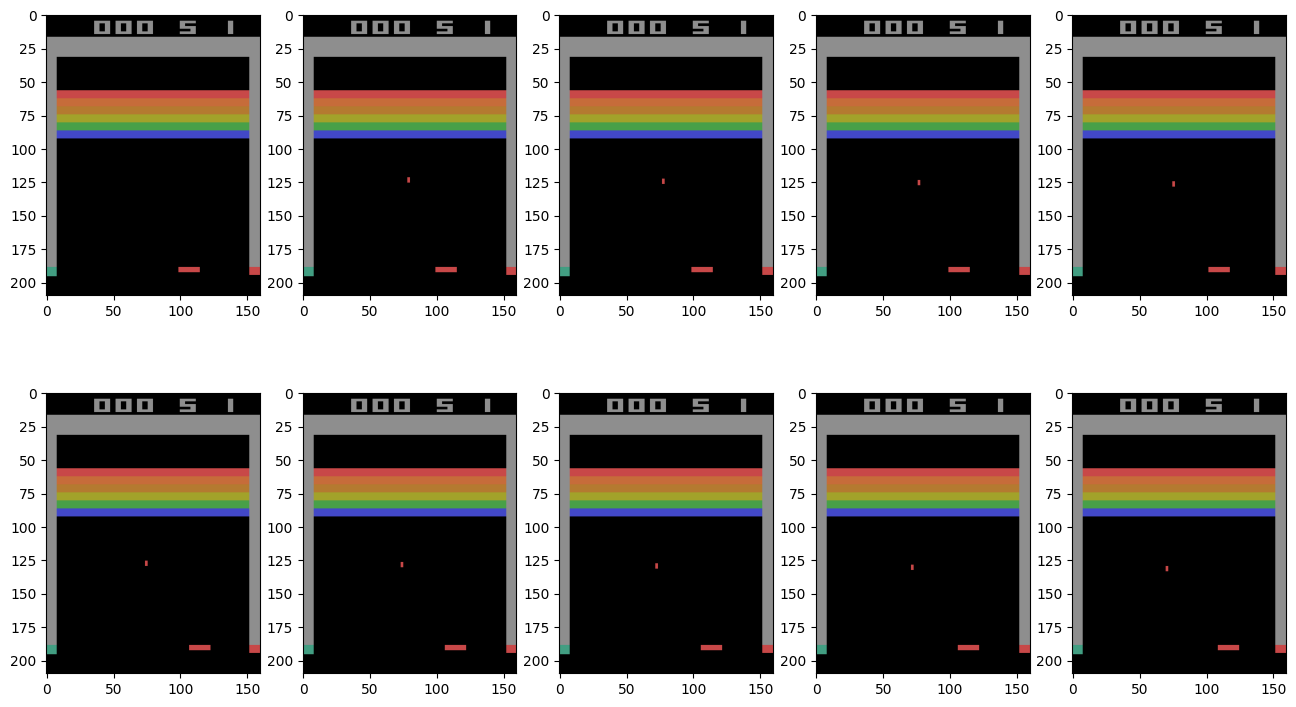

In [6]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

**Let's play a little.**

Pay attention to zoom and fps args of play function. Control: A, D, space.

In [ ]:
# # Does not work in Colab.
# # Use KeyboardInterrupt (Kernel → Interrupt in Jupyter) to continue.

from gymnasium.utils.play import play

play(env=gym.make(ENV_NAME, render_mode="rgb_array"), zoom=4, fps=40)

Box(0, 255, (210, 160, 3), uint8)


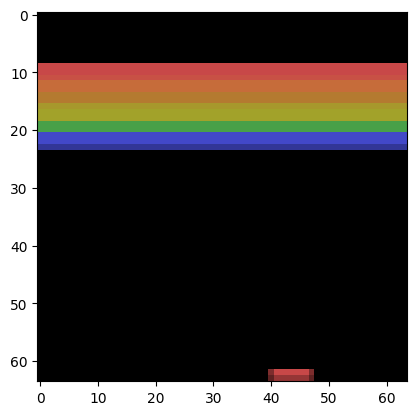

In [60]:
import cv2
print(env.observation_space)
plt.imshow(cv2.resize(env.reset()[0][34:194, 8:152, :], (64, 64)))
plt.show()

In [63]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import cv2


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        super().__init__(env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return np.dot(rgb[..., :3], channel_weights)

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (Use imresize from any library you want,
        #      e.g. opencv, PIL, keras. Don't use skimage.imresize
        #      because it is extremely slow.)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        cropped = img[34:194, 8:152, :]
        resized = cv2.resize(cropped, self.img_size[1:])
        grayscale = self._to_gray_scale(resized)[None]
        return grayscale.astype('float32') / 255
        

Formal tests seem fine. Here's an example of what you'll get.


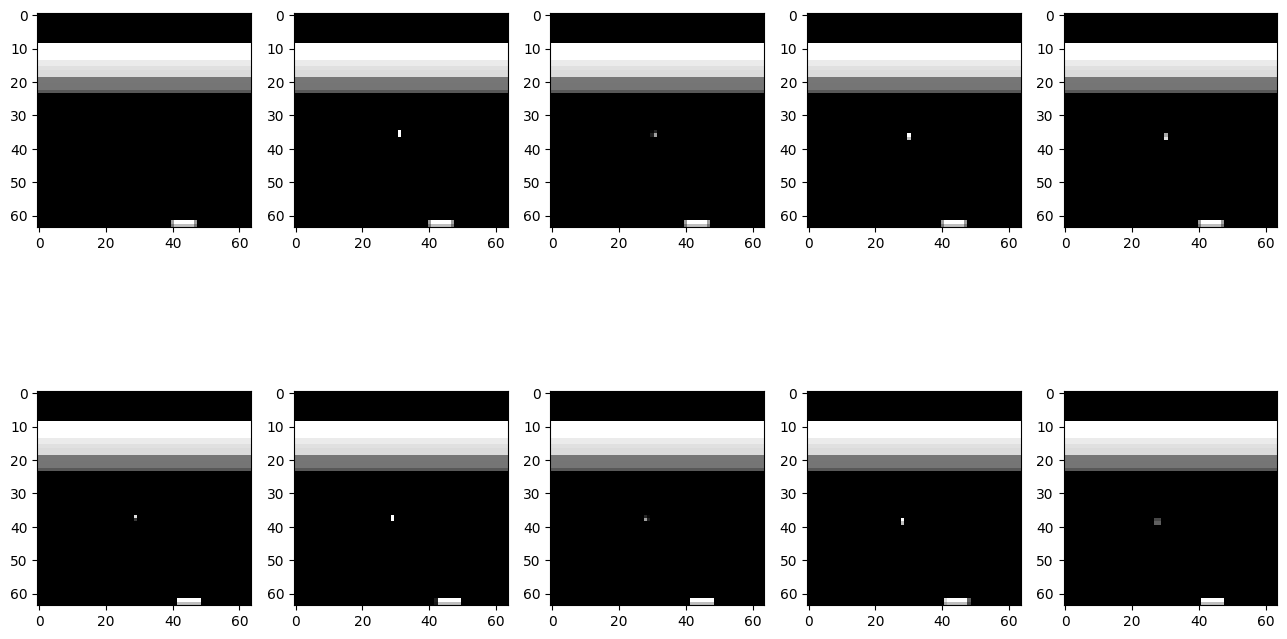

In [64]:
import gymnasium as gym
# spawn game instance for tests
env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape, obs.shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"

assert np.max(obs) >= 0.5, "It would be easier to see a brighter observation"
assert np.mean(obs) >= 0.1, "It would be easier to see a brighter observation"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs, _ = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _, _ = env.step(env.action_space.sample())
plt.show()


### Wrapping.

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

In [65]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 4 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are given by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper launches the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

**Let's see if the game is still playable after applying the wrappers.**
At playing the EpisodicLifeEnv wrapper seems not to work but actually it does (because after when life finishes a new ball is dropped automatically - it means that FireResetEnv wrapper understands that a new episode began).

In [ ]:
# # Does not work in Colab.
# # Use KeyboardInterrupt (Kernel → Interrupt in Jupyter) to continue.

from gymnasium.utils.play import play

def make_play_env():
    env = gym.make(ENV_NAME, render_mode="rgb_array")
    env = PrimaryAtariWrap(env)
# # in torch imgs have shape [c, h, w] instead of common [h, w, c]
    env = atari_wrappers.AntiTorchWrapper(env)
    return env

play(make_play_env(), zoom=4, fps=3)

### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so it must be able to measure object's velocity.

To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you, not really by the staff of the course :)

In [67]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(4, (4, 64, 64))

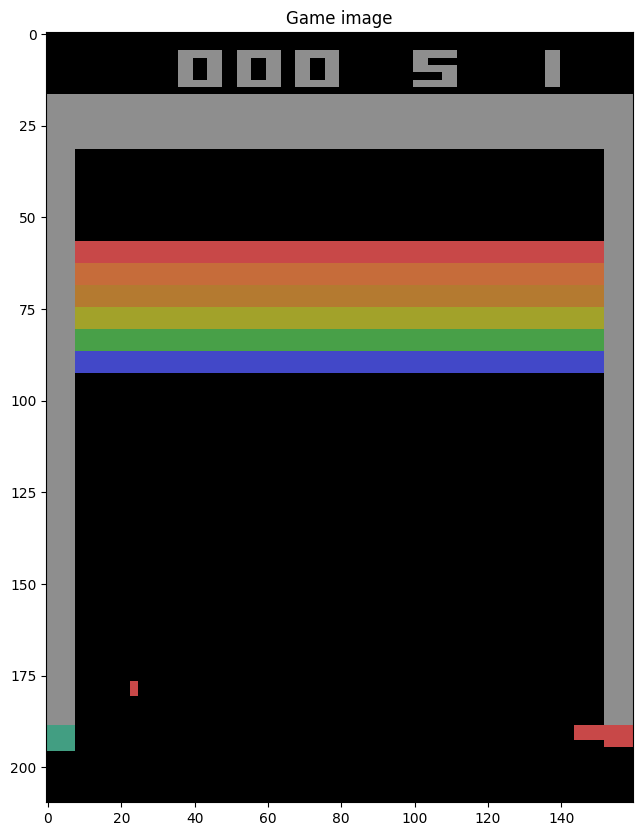

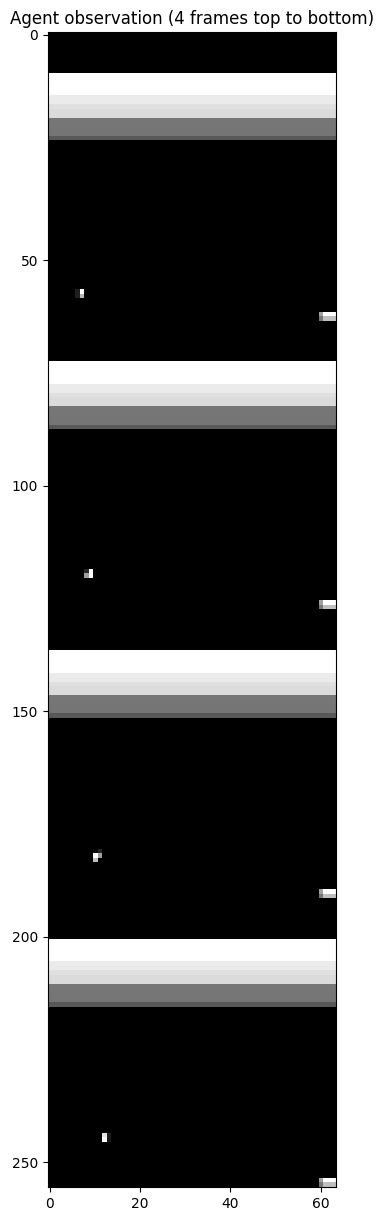

In [68]:
for _ in range(12):
    obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

## DQN as it is (4 pts)

### Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/dqn_arch.png)

**Dueling network: (+2 pts)**
$$Q_{\theta}(s, a) = V_{\eta}(f_{\xi}(s)) + A_{\psi}(f_{\xi}(s), a) - \frac{\sum_{a'}A_{\psi}(f_{\xi}(s), a')}{N_{actions}},$$
where $\xi$, $\eta$, and $\psi$ are, respectively, the parameters of the
shared encoder $f_ξ$ , of the value stream $V_\eta$ , and of the advantage stream $A_\psi$; and $\theta = \{\xi, \eta, \psi\}$ is their concatenation.

For the architecture on the image $V$ and $A$ heads can follow the dense layer instead of $Q$. Please don't worry that the model becomes a little bigger.

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cuda')

In [70]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [76]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0.0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        # nn.Flatten() can be useful
        dense_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_shape[1], 3, 2), 3, 2), 3, 2)
        dense_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(state_shape[2], 3, 2), 3, 2), 3, 2)
        self.flatten = nn.Flatten()

        self.conv1 = nn.Conv2d(state_shape[0], 16, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.dense = nn.Linear(dense_w * dense_h * 64, 256)
        self.q_values = nn.Linear(256, n_actions)

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        qvalues = F.relu(self.conv1(state_t))
        qvalues = F.relu(self.conv2(qvalues))
        qvalues = F.relu(self.conv3(qvalues))
        qvalues = self.flatten(qvalues)
        qvalues = F.relu(self.dense(qvalues))
        qvalues = self.q_values(qvalues)
        

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and 
            qvalues.shape[0] == state_t.shape[0] and 
            qvalues.shape[1] == n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(np.array(states), device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [77]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [78]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000, seed=None):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset(seed=seed)
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [79]:
evaluate(env, agent, n_games=1)

0.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here **to get 2 bonus points**.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [80]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(), 1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [82]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends due to termination or truncation, add record with done=terminated and reset the game.
    It is guaranteed that env has terminated=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, terminated, truncated, _ = env.step(action)
        exp_replay.add(s, action, r, next_s, terminated)
        sum_rewards += r
        s = next_s
        if terminated or truncated:
            s = env.reset()[0]

    return sum_rewards, s

In [83]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, \
    "play_and_record should have added exactly 1000 steps, " \
    "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, \
    "Please make sure you restart the game whenever it is 'done' and " \
    "record the is_done correctly into the buffer. Got %f is_done rate over " \
    "%i steps. [If you think it's your tough luck, just re-run the test]" % (
        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), \
        "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), \
        "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), \
        "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1) for i in is_dones], \
        "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [84]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes Q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

**Double DQN (+2 pts)**

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot
Q_{target}(s',argmax_{a'}Q_\theta(s', a')) $$

In [85]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]  # shape: [batch_size]

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done  # shape: [batch_size]

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, \
            "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [86]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), \
    "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), \
    "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), \
    "target network should not have grads"

## Main loop (3 pts)

**If deadline is tonight and it has not converged:** It is ok. Send the notebook today and when it converges send it again.
If the code is exactly the same points will not be discounted.

It's time to put everything together and see if it learns anything.

In [87]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [88]:
seed = 6969 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [89]:
env = make_env(seed) # why is the seed here?
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quite enough. $10^2$ will probably fail learning.

In [90]:
REPLAY_BUFFER_SIZE = 10**5
N_STEPS = 100

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in trange(REPLAY_BUFFER_SIZE // N_STEPS):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))

 99%|█████████▉| 99/100 [00:14<00:00,  6.72it/s]

10000


In [95]:
timesteps_per_epoch = 1
batch_size = 16
total_steps = 3 * 10**6
decay_steps = 2 * 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [96]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [97]:
import time

def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

buffer size = 100000, epsilon = 0.16075


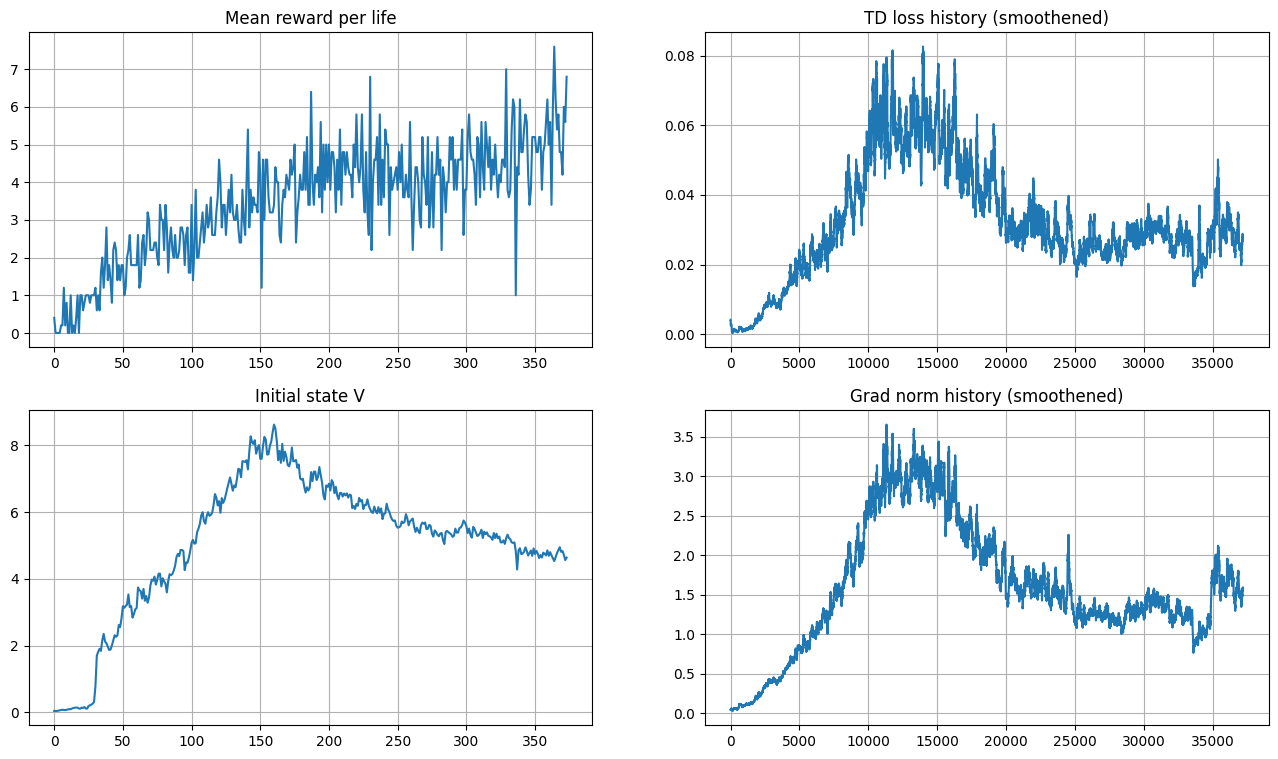

  9%|▉         | 117549/1252362 [21:33<3:28:10, 90.85it/s] 

interrupted


In [143]:
state, _ = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    try:
        for step in progress_bar:
            if not utils.is_enough_ram():
                print('less that 100 Mb RAM available, freezing')
                print('make sure everything is ok and use KeyboardInterrupt to continue')
                wait_for_keyboard_interrupt()

            agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

            # play
            _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

            # train
            sample_batch = exp_replay.sample(batch_size)

            loss = compute_td_loss(*sample_batch, agent, target_network, gamma=0.99, device=device)

            loss.backward()
            grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
            opt.step()
            opt.zero_grad()

            if step % loss_freq == 0:
                td_loss_history.append(loss.data.cpu().item())
                grad_norm_history.append(grad_norm.cpu())

            if step % refresh_target_network_freq == 0:
                # Load agent weights into target_network
                target_network.load_state_dict(agent.state_dict())

            if step % eval_freq == 0:
                mean_rw_history.append(evaluate(
                    make_env(clip_rewards=True), agent, n_games=3 * n_lives, greedy=True, seed=step)
                )
                initial_state_q_values = agent.get_qvalues(
                    [make_env().reset(seed=step)[0]]
                )
                initial_state_v_history.append(np.max(initial_state_q_values))

                clear_output(True)
                print("buffer size = %i, epsilon = %.5f" %
                    (len(exp_replay), agent.epsilon))

                plt.figure(figsize=[16, 9])

                plt.subplot(2, 2, 1)
                plt.title("Mean reward per life")
                plt.plot(mean_rw_history)
                plt.grid()

                assert not np.isnan(td_loss_history[-1])
                plt.subplot(2, 2, 2)
                plt.title("TD loss history (smoothened)")
                plt.plot(utils.smoothen(td_loss_history))
                plt.grid()

                plt.subplot(2, 2, 3)
                plt.title("Initial state V")
                plt.plot(initial_state_v_history)
                plt.grid()

                plt.subplot(2, 2, 4)
                plt.title("Grad norm history (smoothened)")
                plt.plot(utils.smoothen(grad_norm_history))
                plt.grid()

                plt.show()
    except KeyboardInterrupt:
        print('interrupted')

Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. Cuz this is what environment the agent is learning in and in this way mean rewards per life can be compared with initial state value

**The goal is to get 15 points in the real env**. So 3 or better 4 points in the preprocessed one will probably be enough. You can interrupt learning then.

Final scoring is done on a whole episode with all 5 lives.

In [144]:
final_score = evaluate(
  make_env(clip_rewards=False),
    agent, n_games=30, greedy=True, t_max=10 * 1000, seed=9
)
print('final score:', final_score)
assert final_score >= 3, 'not as cool as DQN can'
print('Cool!')

final score: 8.4
Cool!


## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously.
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...).
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agaent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

**Training will take time.** A lot of it actually. Probably you will not see any improvment during first **150k** time steps (note that by default in this notebook agent is evaluated every 5000 time steps).

But hey, long training time isn't _that_ bad:
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/training.png)

## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (imagine the agent collecting data to the buffer always manages to avoid the ball).

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* batch size: This one can be very important: if it is too small the agent can fail to learn. Huge batch takes more time to process. If batch of size 8 can not be processed on the hardware you use take 2 (or even 4) batches of size 4, divide the loss on them by 2 (or 4) and make optimization step after both backward() calls in torch.

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow leraning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.
* max_grad_norm - just huge enough. In torch clip_grad_norm also evaluates the norm before clipping and it can be convenient for logging.

### Video

In [ ]:
# record sessions
from gymnasium.wrappers import RecordVideo

with make_env() as env, RecordVideo(
    env=env, video_folder="./videos", episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [
        evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(5)
    ]


In [146]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[0] # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Let's have a closer look at this.

If average episode score is below 200 using all 5 lives, then probably DQN has not converged fully. But anyway let's make a more complete record of an episode.

In [147]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

total reward for life: 15.0
states
v_mc
v_agent
q_spreads
td_errors
rewards
episode_finished


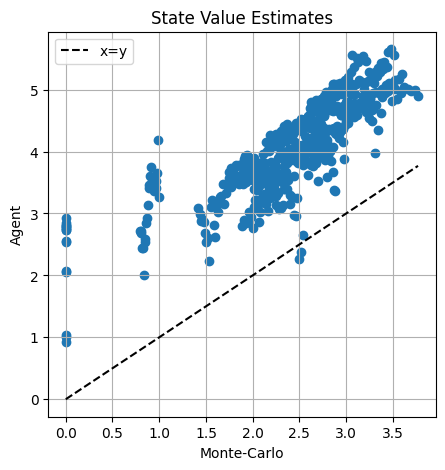

In [148]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()

$\hat V_{Monte-Carlo}(s_t) = \sum_{\tau=0}^{episode~end} \gamma^{\tau-t}r_t$

Is there a big bias? It's ok, anyway it works.

## Bonus I (2 pts)

**1.** Plot several (say 3) states with high and low spreads of Q estimate by actions i.e.
$$\max_a \hat Q(s,a) - \min_a \hat Q(s,a)\$$
Please take those states from different episodes to make sure that the states are really different.

What should high and low spread mean at least in the world of perfect Q-fucntions?

Comment the states you like most.

**2.** Plot several (say 3) states with high td-error and several states with high values of
$$| \hat V_{Monte-Carlo}(s) - \hat V_{agent}(s)|,$$
$$\hat V_{agent}(s)=\max_a \hat Q(s,a).$$ 

Please take those states from different episodes to make sure that the states are really different. From what part (i.e. beginning, middle, end) of an episode did these states come from?

Comment the states you like most.

In [ ]:
from utils import play_and_log_episode, img_by_obs

<YOUR CODE>

## Bonus II (1-5 pts). Get High Score!

1 point to you for each 50 points of your agent. Truncated by 5 points. Starting with 50 points, **not** 50 + threshold.

One way is to train for several days and use heavier hardware (why not actually).

Another way is to apply modifications (see **Bonus III**).

## Bonus III (2+ pts). Apply modifications to DQN.

For inspiration see [Rainbow](https://arxiv.org/abs/1710.02298) - a version of q-learning that combines lots of them.

Points for Bonus II and Bonus III fully stack. So if modified agent gets score 250+ you get 5 pts for Bonus II + points for modifications. If the final score is 40 then you get the points for modifications.


Some modifications:
* [Prioritized experience replay](https://arxiv.org/abs/1511.05952) (5 pts for your own implementation, 3 pts for using a ready one)
* [double q-learning](https://arxiv.org/abs/1509.06461) (2 pts)
* [dueling q-learning](https://arxiv.org/abs/1511.06581) (2 pts)
* multi-step heuristics (see [Rainbow](https://arxiv.org/abs/1710.02298)) (3 pts)
* [Noisy Nets](https://arxiv.org/abs/1706.10295) (3 pts)
* [distributional RL](https://arxiv.org/abs/1707.06887)(distributional and distributed stand for different things here) (5 pts)
* Other modifications (2+ pts depending on complexity)

## Bonus IV (4+ pts). Distributed RL.

Solve the task in a distributed way. It can strongly speed up learning. See [article](https://arxiv.org/pdf/1602.01783.pdf) or some guides.

**As usual bonus points for all the tasks fully stack.**